# Exercise 4
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Write **efficient vectorized** code whenever possible. 
1. You should add as many tests as you see fit. Tests will not be graded nor checked.
1. Do not change the functions we provided you. 
1. Your code must run without errors. Use `python 3`, and at least `numpy 1.15.4` and `pytorch 1.0`. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. 
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.

In [1]:
import os
import sys
import copy
import time
import random
import collections
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
import torchvision.models as models

from data.dataloader import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

print(torch.__version__)

%load_ext autoreload
%autoreload 2

1.2.0.dev20190805


# Localization as Regression (50 points)

State of the art accuracy on CIFAR10 is currently ~99% on the test set. In this part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and the pretrained ResNet18 available in pytorch correctly classifies ~70% of the test set. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can create learn a model that can also localize cats and dogs using very few images. 

You are provided with a dataset that contains images, classes and a single bounding box coordinates per image.

In [5]:
data_transforms = {
    'train': T.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=16, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [3]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))
# #data_transforms['train']()
# pp= {'image':np.ndarray(shape=(100,100)), 'bbox':np.array( [ 99, 11, 278, 173]), 'label':np.array([1,0,1])}
# data_transforms['train'](pp)

<Figure size 432x288 with 0 Axes>

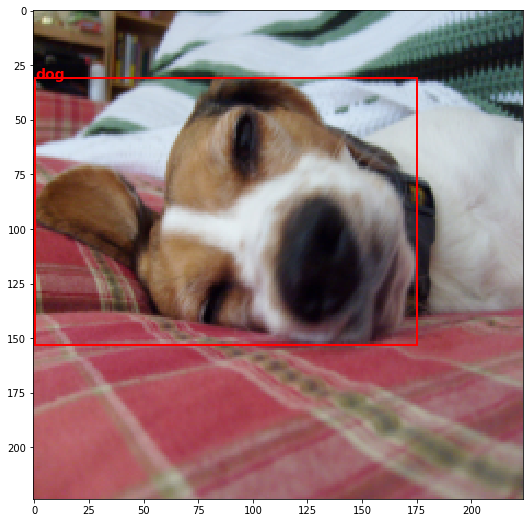

In [4]:
def imshow(img, label, bbox):
    img = img[0]
    inv_normalize = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(np.transpose(img, (1, 2, 0))); # plt accepts images in the format (w,h,c)
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', weight='bold', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [65]:
# xx = sample['bbox'][0]
# xx
# x1, y1, x2, y2 = xx.numpy().reshape(-1) * 224
# x1,y1,x2, y2,xx.numpy().reshape(-1)
# box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
# bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2,
#                              edgecolor='r', facecolor='none');
# bbox.get_xy()
# arr = np.zeros(shape=(224,224))
# arr[int(y1):int(y1)+int(box_h)][int(x1): int(x1) + int(box_w)]=1
# fig, ax = plt.subplots(1, figsize=(12,9));
# ax.imshow(arr);
# bb = model_without_last_layer(sample['image'])
# # nn.Linear(512, 2)(bb.squeeze(3))
# bb.reshape(16, -1).shape, bb.shape, nn.Linear(512, 2)(bb.reshape(16, -1)).shape

features = nn.Sequential(*list(model.children())[:-1])
classifier = nn.Sequential(nn.AvgPool2d(7, stride=1))


# model.avgpool = nn.AvgPool2d(7, stride=1) #input size : 512X7X7 output size 512X1
# model.fc = nn.Linear(512 * 1, 2)

features(sample['image']).shape

torch.Size([16, 512, 1, 1])

In [84]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained = True)
# model_without_last_layer = nn.Sequential(*list(model.children())[: -1], nn.Conv2d(512, 3, 1))


# model_without_last_layer = nn.Sequential(*list(model.children())[: -1])

# model_without_last_layer = nn.Sequential(*list(model.children())[: -1])
        

model_without_last_layer(sample['image']).shape,sample['image'].shape,sample['label'].shape

base = list(model.children())[: -1]
for param in base :
    param.requires_grad = False

    
model.fc = nn.Sequential(
    nn.Linear(512, 2)
)

#model(sample['image']).shape

for x in list(model.children())[-1][0].parameters():
    print(x.requires_grad)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


True
True


In [43]:
list(model.children())[-1]

Linear(in_features=512, out_features=1000, bias=True)

In [93]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully           #
        # connected layer, so we could pass the features of the convolutional       #
        # network and not only the classification layer which carries significantly #
        # less information.                                                         #
        # Afterwards, create a new sequential model which includes the resnet and   #
        # add a new fully connected layer that outputs a vector with the size of    #
        # the wanted dimensionality.                                                #
        # This function has no return value.                                        #
        #############################################################################
        self.classification_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained = True)
        base = list(self.classification_model.children())[: -1]
        for param in base :
            param.requires_grad = False
        
        self.classification_model.fc = nn.Sequential(nn.Linear(512, num_classes))
        
        
        self.bb_model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained = True)
        base = list(self.bb_model.children())[: -1]
        for param in base :
            param.requires_grad = False
        
        self.bb_model.fc = nn.Sequential(nn.Linear(512, 4))
        
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # perdefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box.             #
        #############################################################################
        pred = self.classification_model(images)
        bbox = self.bb_model(images)
        return pred, bbox
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 

In [159]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
              

                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                
                optimizer.zero_grad()
                inputs = sample['image'].to(device)
                bbox = sample['bbox'].to(device)
                
                labels = sample['label'].to(device)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, bbox_output = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion_cls(outputs, labels)
                
                    for x in range(bbox.shape[0]):
                        iou += bb_intersection_over_union(bbox_output[x], bbox[x])
                        
                    loss += criterion_bbox(bbox_output, bbox)
                    
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                     
                    
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            #todo: fix
            iou = iou.item() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [160]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = nn.CrossEntropyLoss().to(device)
criterion_bbox = nn.MSELoss().to(device)
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


Training large neural networks may take a while - make sure the number of trainable parameters in your model fits the computational power you possess. For this exercise, you are encouraged to try Google Colab or a free AWS / Google Cloud Platform / Azure available for students. Training our one of our networks on a Core i7 CPU for 10 epochs took 5 minutes and reached 99% classification accurcay and over 0.75 IOU score on the validation set (this took less than a minute on a GPU). 

In order to get full marks for this section, reach at least 98% classification accuracy and a IOU score of at least 0.75 on the validation set using a single model.

In [164]:
best_model = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.1350  |  Acc: 0.9764  |  IOU: 0.5851
val Loss: 0.1092  |  Acc: 1.0000  |  IOU: 0.5558
Epoch 1/99
----------
train Loss: 0.0838  |  Acc: 0.9874  |  IOU: 0.6412
val Loss: 0.0841  |  Acc: 1.0000  |  IOU: 0.5836
Epoch 2/99
----------
train Loss: 0.0601  |  Acc: 0.9953  |  IOU: 0.6827
val Loss: 0.0802  |  Acc: 1.0000  |  IOU: 0.6015
Epoch 3/99
----------
train Loss: 0.0494  |  Acc: 0.9953  |  IOU: 0.7069
val Loss: 0.0682  |  Acc: 1.0000  |  IOU: 0.6104
Epoch 4/99
----------
train Loss: 0.0450  |  Acc: 0.9953  |  IOU: 0.7264
val Loss: 0.0724  |  Acc: 0.9937  |  IOU: 0.6155
Epoch 5/99
----------
train Loss: 0.0339  |  Acc: 0.9969  |  IOU: 0.7399
val Loss: 0.0659  |  Acc: 0.9937  |  IOU: 0.6153
Epoch 6/99
----------
train Loss: 0.0273  |  Acc: 1.0000  |  IOU: 0.7439
val Loss: 0.0688  |  Acc: 0.9937  |  IOU: 0.6145
Epoch 7/99
----------
train Loss: 0.0235  |  Acc: 1.0000  |  IOU: 0.7486
val Loss: 0.0618  |  Acc: 1.0000  |  IOU: 0.6197
Epoch 8/99
----------
tr

KeyboardInterrupt: 

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

<Figure size 432x288 with 0 Axes>

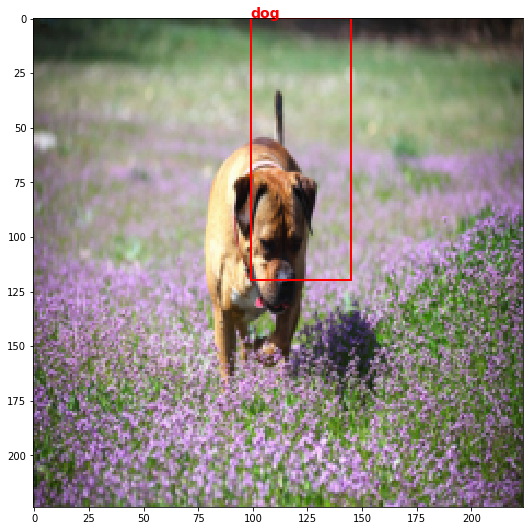

In [165]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

# Part 2: Recurrent Neural Networks (50 points)

This part will be composed out of two steps:

1. Understanding and implementing the vanilla RNN cell. As you learned in class, the RNN has a certain structure that allows it to accept the previous hidden state the current input, and output an hidden state and an output vector. The RNN cell uses the same weights for all time steps, much like convolution uses the same weights for all the batches in the image. Even though you already are familiar with PyTorch, implementing the RNN you make sure you understand how this pivotal architecture works.
2. Using PyTorch to create a simple text generator. You will create a neural network using RNN cells and train it on your favorite text. Next, your network will generate text that "feels" like the text it was trained on. 

## Helper functions

In [166]:
def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

# Vanilla RNN: step forward (7.5 points)

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors less than 1e-8.

In [167]:
def rnn_step_forward(x, prev_h, Wx, Wh, b):
    """
    Run the forward pass for a single timestep of a vanilla RNN that uses a tanh
    activation function.

    The input data has dimension D, the hidden state has dimension H, and we use
    a minibatch size of N.

    Inputs:
    - x: Input data for this timestep, of shape (N, D).
    - prev_h: Hidden state from previous timestep, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - next_h: Next hidden state, of shape (N, H)
    - cache: Tuple of values needed for the backward pass.
    """
    next_h, cache = None, None
    ##############################################################################
    # TODO: Implement a single forward step for the vanilla RNN. Store the next  #
    # hidden state and any values you need for the backward pass in the next_h   #
    # and cache variables respectively.                                          #
    ##############################################################################
#     next_h = np.tanh(np.dot(x, Wx) + np.dot(prev_h, Wh) + b)
#     cache = (next_h, x, prev_h, Wh, Wx)
    next_h = np.tanh(np.dot(x,Wx) + np.dot(prev_h,Wh) + b)
    cache = x, prev_h, Wx, Wh, next_h
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return next_h, cache

In [168]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward (7.5 points)

In [8]:
def rnn_step_backward(dnext_h, cache):
    """
    Backward pass for a single timestep of a vanilla RNN.

    Inputs:
    - dnext_h: Gradient of loss with respect to next hidden state
    - cache: Cache object from the forward pass

    Returns a tuple of:
    - dx: Gradients of input data, of shape (N, D)
    - dprev_h: Gradients of previous hidden state, of shape (N, H)
    - dWx: Gradients of input-to-hidden weights, of shape (D, H)
    - dWh: Gradients of hidden-to-hidden weights, of shape (H, H)
    - db: Gradients of bias vector, of shape (H,)
    """
    dx, dprev_h, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a single step of a vanilla RNN.      #
    #                                                                            #
    # HINT: For the tanh function, you can compute the local derivative in terms #
    # of the output value from tanh.                                             #
    ##############################################################################
    x, prev_h, Wx, Wh, next_h = cache
    dtanh = 1- next_h**2
    dx = np.dot(dnext_h*dtanh, Wx.T)
    dWx = np.dot(x.T, dnext_h*dtanh)
    dprev_h = np.dot(dnext_h*dtanh, Wh.T)
    dWh = np.dot(prev_h.T, dnext_h*dtanh)
    db = np.sum(dnext_h*dtanh, 0)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dprev_h, dWx, dWh, db

In [9]:
np.random.seed(1337)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  7.016693365073193e-10
dprev_h error:  1.9940865711627726e-08
dWx error:  6.641141198152417e-10
dWh error:  1.0193306662954873e-09
db error:  6.240004056346829e-10


# Vanilla RNN: forward (7.5 points)
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that process an entire sequence of data.

In [10]:
def rnn_forward(x, h0, Wx, Wh, b):
    """
    Run a vanilla RNN forward on an entire sequence of data. We assume an input
    sequence composed of T vectors, each of dimension D. The RNN uses a hidden
    size of H, and we work over a minibatch containing N sequences. After running
    the RNN forward, we return the hidden states for all timesteps.

    Inputs:
    - x: Input data for the entire timeseries, of shape (N, T, D).
    - h0: Initial hidden state, of shape (N, H)
    - Wx: Weight matrix for input-to-hidden connections, of shape (D, H)
    - Wh: Weight matrix for hidden-to-hidden connections, of shape (H, H)
    - b: Biases of shape (H,)

    Returns a tuple of:
    - h: Hidden states for the entire timeseries, of shape (N, T, H).
    - cache: Values needed in the backward pass
    """
    h, cache = None, None
    ##############################################################################
    # TODO: Implement forward pass for a vanilla RNN running on a sequence of    #
    # input data. You should use the rnn_step_forward function that you defined  #
    # above. You can use a for loop to help compute the forward pass.            #
    ##############################################################################
    prev_h = h0
    h = np.ndarray(shape=(x.shape[0], x.shape[1], h0.shape[1]))
    cache = {}
    
    for i in range(x.shape[1]):
        current_x = x[:, i, :]
        prev_h, stem_cache  = rnn_step_forward(current_x, prev_h, Wx, Wh, b)
        cache[i] = stem_cache
        h[:, 1, :] = prev_h
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return h, cache

In [11]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  1.0


# Vanilla RNN: backward (7.5 points)

In [12]:
def rnn_backward(dh, cache):
    """
    Compute the backward pass for a vanilla RNN over an entire sequence of data.

    Inputs:
    - dh: Upstream gradients of all hidden states, of shape (N, T, H)

    Returns a tuple of:
    - dx: Gradient of inputs, of shape (N, T, D)
    - dh0: Gradient of initial hidden state, of shape (N, H)
    - dWx: Gradient of input-to-hidden weights, of shape (D, H)
    - dWh: Gradient of hidden-to-hidden weights, of shape (H, H)
    - db: Gradient of biases, of shape (H,)
    """
    dx, dh0, dWx, dWh, db = None, None, None, None, None
    ##############################################################################
    # TODO: Implement the backward pass for a vanilla RNN running an entire      #
    # sequence of data. You should use the rnn_step_backward function that you   #
    # defined above. You can use a for loop to help compute the backward pass.   #
    ##############################################################################
    x, prev_h, Wx, Wh, next_h = cache[0]
    length = len(cache)

    
    dx = np.zeros((x.shape[0], length, x.shape[1]))
    dprev_h = np.zeros((x.shape[0], next_h.shape[1]))
    dWx = np.zeros((x.shape[1], next_h.shape[1], length))
    dWh = np.zeros((next_h.shape[1], next_h.shape[1], length))
    db = np.zeros((next_h.shape[1], length))
  
    dnext_h = dh[:, length-1, :]
    i = T - 1

    while i >= 0:
        dx[:,i,:], dprev_h, dWx[:, :, i], dWh[:, :, i], db[:, i] = rnn_step_backward(dnext_h, cache[i])
        if i > 0:
            dnext_h = dh[:,i-1,:] + dprev_h

        i = i - 1
          
    dh0 = dprev_h
    dWx = np.sum(dWx, 2)
    dWh = np.sum(dWh, 2)
    db = np.sum(db, 1)
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return dx, dh0, dWx, dWh, db

In [14]:
np.random.seed(1337)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.0
dh0 error:  1.0
dWx error:  1.0
dWh error:  1.0
db error:  1.0


# Generating text using RNNs (20 points)

Using PyTorch, create a network that is capable of generating text, similar to the text it has seen during training. In order to tackle this problem, first read the [following blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) by Andrej Karpathy for some creative uses of this network and his implemention of a [char-based RNN in pure numpy](https://gist.github.com/karpathy/d4dee566867f8291f086). 

While implementing your own network (in PyTorch), make sure to consider the following:

1. Get a large enough text file, with proper encoding. A solid place to start should the creations of [Shakespere](https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt). You are encourged to try different datasets with amusing outcomes.
2. Encode the text and map each character to an integer. One-hot encoding might also be a good idea.
3. You might be temped to use a dataloader, however defining your own method to obtain training batches might be easier.
4. Define your model. The following guide will help you understand how to use RNNs in PyTorch: [RNN text classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html). You model should be relatively simple.
5. Train your model. Training a proper model might take a while, so you are encoraged to use [Colab](https://colab.research.google.com/).
6. Create a function that takes the learned network and predicts a single character. This function should take a hidden state and an input character, and output the next hidden state and the predicted character.
7. Finally, create a sampling function that takes the network, the required length of text to generate and an initial input and generate some text.

In [3]:
import re
with open('data/shakespeare.txt', 'r') as f:
    text = f.read().lower()
text = re.sub(' +', ' ', text)
text = re.sub(' \n', ' ', text)
total_text_length = len(text)
total_text_length

5060431

In [4]:
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
all_leters = set(text)
index_to_letter = {i: l for (i, l) in  enumerate(all_leters)}
letter_to_index = {letter: index for (index, letter) in index_to_letter.items()}
n_letters = len(letter_to_index)
end_of_sentense_letter_index = n_letters

In [6]:
def indexToLetter(index):
    return index_to_letter[index]

def letterToIndex(letter):
    return letter_to_index[letter]

def letterToVector(letter):
    return letterIndexToVector(letterToIndex(letter))

def letterIndexToVector(letter_index):
    vec = np.zeros(n_letters)
    vec[letter_index] = 1
    return vec

def textToTensor(value):
    vectors = np.zeros(shape = (len(value), n_letters), dtype=np.int)
    for c in range(len(value)):
        vectors[c] =  letterToVector(value[c])
        
    return Variable(torch.from_numpy(vectors))

def lettersIndexTensor(value):    
    return  torch.from_numpy(np.array([letterToIndex(letter) for letter in value]))    

In [7]:
textToTensor('b'), letterToVector('b')

(tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

In [8]:
TRAINNING_TEXT_LENGTH = 150

def select_text():
    start_index = random.randint(0, total_text_length - TRAINNING_TEXT_LENGTH)
    end_index = start_index + TRAINNING_TEXT_LENGTH + 1
    return text[start_index: end_index]

In [10]:
def generate_trainning_sample():
    sample_text = select_text()
    input_letters_vectors = textToTensor(sample_text[:-1])
    target_letters = lettersIndexTensor(sample_text[1:])
    
    return input_letters_vectors, target_letters

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size=input_size, hidden_size =  hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(input.view(1, 1, -1), hidden)
        output = self.fc(output.view(1, -1))
        
        return  output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [14]:
def train(input_letters, target):
    model.train()
    
    hidden = model.init_hidden().to(device)
    model.zero_grad()
    loss = 0
        
    in_text_length = input_letters.shape[0]
    chunc_out = torch.zeros(size =(in_text_length, n_letters)).to(device)
    input_letters = Variable(input_letters).float().to(device)
    target = Variable(target).long().to(device)
    
    for c in range(in_text_length):
        output, hidden = model(input_letters[c], hidden)
        chunc_out[c] = output

    loss += criterion(chunc_out, target)

    loss.backward()
    optimizer.step()

    return loss.item() / in_text_length

In [107]:
n_epochs = 3000
print_every = 200
hidden_size = 100
num_of_layers = 1
lr = 0.005

model = RNN(n_letters, hidden_size, n_letters, num_of_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*generate_trainning_sample())
    loss_avg += loss

    if epoch % print_every == 0:
        print('epoc - {} percentage - {} loss - {}'.format(epoch, epoch / n_epochs * 100, loss))
        losses.append(loss_avg / print_every)
        loss_avg = 0

        


NameError: name 'RNN' is not defined

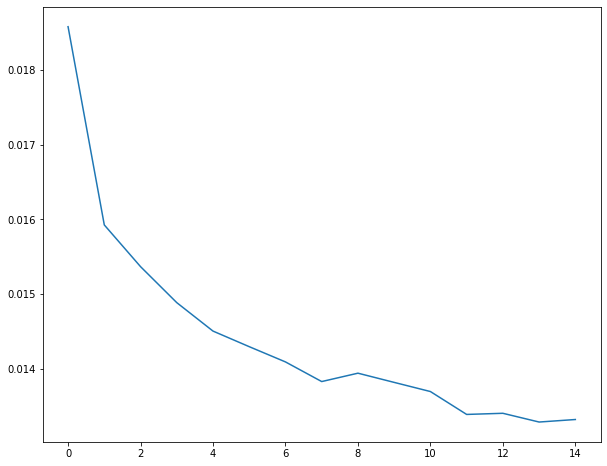

In [23]:
plt.plot(losses)
plt.show()

In [36]:
def generateTxet(model, length, initial):
    model.eval()
    generated_text = initial
    with torch.no_grad():
        input_letter = textToTensor(initial)
        hidden = model.init_hidden().to(device)
        input_letter = Variable(input_letter).float().to(device)
        
        for _ in range(length):
            output, hidden = model(input_letter, hidden)
            output_dist = output.data.view(-1).div(0.8).exp()
            top_letter_index = torch.multinomial(output_dist, 1)[0].detach().cpu().numpy().item()
            letter = indexToLetter(top_letter_index)
            generated_text += letter
            input_letter = textToTensor(letter)
            input_letter = Variable(input_letter).float().to(device)
    
    return generated_text

In [39]:
generateTxet(model, 200, 't')

"the will gryede;\n shere my miss reardiesterk.\nwproule parleon. i wough now hear heart maired\n shere, do hery,\n and i sughon me i'll make i the runter, i mied you this them mide; the rony.\n plof lood on"